# Student Dropout Analysis

**Annabel Lim, Owen Kwong, Yash Mali, Yui Mikuriya (Group 20)**

## 1. Introduction

**Research Question:** *Is there enough evidence to suggest that admission grades of students that dropped out are lower than those of students that graduated?*

Higher education institutions worldwide are attempting to effectively address diverse student learning styles and academic performances to enhance the learning experience. One interesting topic to consider is the dropout rate within higher education along with exploration of its root causes. There are many factors that could impact the likelihood of a student to drop out such as mental health issues, financial challenges, and weak academic backgrounds.

The goal of this project is to determine if students that dropped out had lower admission grades than the students who graduated. The Polytechnic Institute of Portalegre (IPP) has a dataset with student data from four schools in Portugal. It provides data on factors such as nationality, admission grades, and graduation status. 


## 2. Preliminary Results

### Libraries, seed, table rows

In [34]:
# load libraries
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(dplyr)
library(datateachr)

# set seed
set.seed(2023);

# number rows for table 
options(repr.matrix.max.rows = 8)

### Importing Data

In [35]:
# data url (zip file)
url <- "https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip"


# unzip and load data
temp <- tempfile()
download.file(url,temp)
dropout_data <- read.csv2(unz(temp, "data.csv")) 
unlink(temp)

dropout_data # shows that there are 4424 student entries

Marital.status,Application.mode,Application.order,Course,Daytime.evening.attendance.,Previous.qualification,Previous.qualification..grade.,Nacionality,Mother.s.qualification,Father.s.qualification,⋯,Curricular.units.2nd.sem..credited.,Curricular.units.2nd.sem..enrolled.,Curricular.units.2nd.sem..evaluations.,Curricular.units.2nd.sem..approved.,Curricular.units.2nd.sem..grade.,Curricular.units.2nd.sem..without.evaluations.,Unemployment.rate,Inflation.rate,GDP,Target
<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
1,17,5,171,1,1,122.0,1,19,12,⋯,0,0,0,0,0.0,0,10.8,1.4,1.74,Dropout
1,15,1,9254,1,1,160.0,1,1,3,⋯,0,6,6,6,13.666666666666666,0,13.9,-0.3,0.79,Graduate
1,1,5,9070,1,1,122.0,1,37,37,⋯,0,6,0,0,0.0,0,10.8,1.4,1.74,Dropout
1,17,2,9773,1,1,122.0,1,38,37,⋯,0,6,10,5,12.4,0,9.4,-0.8,-3.12,Graduate
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,1,2,9773,1,1,120.0,105,1,1,⋯,0,6,6,2,11.0,0,11.1,0.6,2.02,Dropout
1,1,1,9500,1,1,154.0,1,37,37,⋯,0,8,9,1,13.5,0,13.9,-0.3,0.79,Dropout
1,1,1,9147,1,1,180.0,1,37,37,⋯,0,5,6,5,12.0,0,9.4,-0.8,-3.12,Graduate
1,10,1,9773,1,1,152.0,22,38,37,⋯,0,6,6,6,13.0,0,12.7,3.7,-1.7,Graduate


Figure 1. Imported tibble of IPP student dropout data

### Cleaning the Data

In [71]:
# clean data
dropout_clean <- dropout_data %>% 
    mutate(Target = as_factor(Target)) %>% # changed target to factor type
    filter(Target != "Enrolled") # removed enrolled students because ambiguous (~900 students)
#In our case, there is no need to filter out NA as there are none in the Status and Grade parameters that we are interested in 

names(dropout_clean)[names(dropout_clean) == "Target"] <- "Status"
names(dropout_clean)[names(dropout_clean) == "Previous.qualification..grade."] <- "Grade"
names(dropout_clean)[names(dropout_clean) == "Admission.grade"] <- "Admission_Grade"

dropout_pop <- dropout_clean %>% 
select(Status, Admission_Grade,Grade) %>%#select only the parameters of interest
mutate(Grade = as.numeric(Grade), Admission_Grade = as.numeric(Admission_Grade))

head(dropout_pop)

In [79]:
dropout_count <- dropout_pop %>%
group_by(Status) %>%
summarize(count_column = n()) 
dropout_count 
# Comment for team -> Is this a fair amount of data we have on both> I think so (Yui)

Status,count_column
<fct>,<int>
Dropout,1421
Graduate,2209


In [92]:
dropout_summarize <- dropout_pop %>%
group_by(Status) %>%
summarize(mean_grade = mean(Grade), mean_admission_grade = mean(Admission_Grade)) # WE decided to take population mean as the appropriate quantity to help answer our question
dropout_summarize

dropout_mean <- dropout_summarize["1","mean_admission_grade", drop=TRUE]
graduates_mean <- dropout_summarize["2","mean_admission_grade", drop=TRUE]

Status,mean_grade,mean_admission_grade
<fct>,<dbl>,<dbl>
Dropout,131.1141,124.9614
Graduate,134.0827,128.7944


[1] 124.9614

[1] 128.7944

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


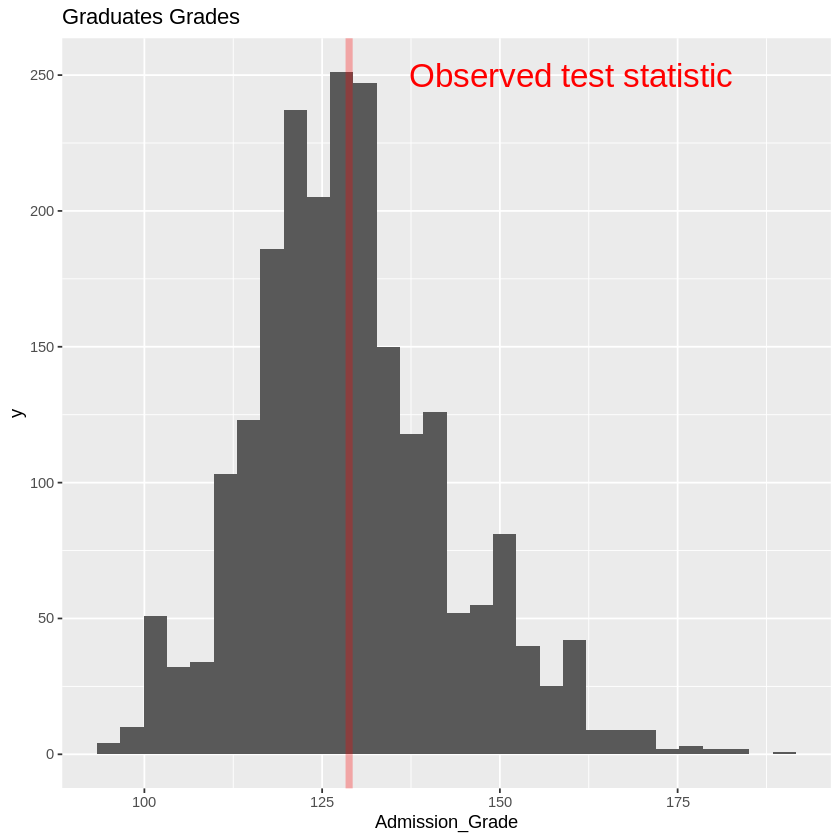

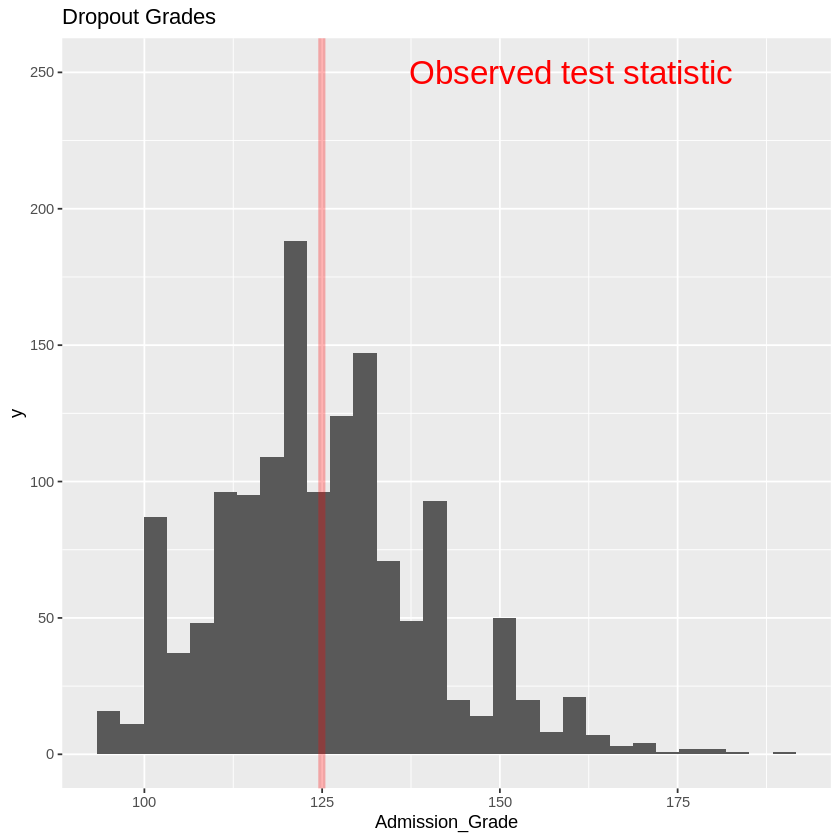

In [101]:
dropout_distribution <- dropout_pop %>%
filter(Status == "Graduate") %>%
ggplot() +
geom_histogram(aes(x=Admission_Grade)) +
ggtitle("Graduates Grades") +
geom_vline(xintercept = graduates_mean, color = "red", alpha=.3, lwd=2) + 
annotate("text", x = 160, y = 250, label = "Observed test statistic", color="red", size=7)

dropout_distribution2 <- dropout_pop %>%
filter(Status == "Dropout") %>%
ggplot() +
geom_histogram(aes(x=Admission_Grade)) +
ggtitle("Dropout Grades") +
geom_vline(xintercept = dropout_mean, color = "red", alpha=.3, lwd=2) + 
annotate("text", x = 160, y = 250, label = "Observed test statistic", color="red", size=7)

dropout_distribution
dropout_distribution2

Figure 2. Tidied tibble of IPP student dropout data

### Variables Information

The description of columns are given by the data set information on the UCI Machine Learning Repository page.

**Admission.grade:** Students' admission grade is standardized (0-200).

**Target:** Student can be classified as three different types (dropout, enrolled, graduate).

*Can add more if we need to*

### Regrouping the Response Variable 

*May not need this. Depending on how we interact with dropout/enrolled/graduate*

### Data Analysis and Visualizations

*Can do visualizations and estimates here*

## 3. Methods: Plan

The credibility of this report hinges on a reliable dataset, as the IPP has previously leveraged this data to construct machine learning classification models for forecasting students' challenges in completing their degrees.

We plan to conduct a one sided hypothesis test to examine if there is enough evidence to suggest that the admission grades of dropout students are lower than those of students who graduate. Furthermore, we can use a confidence interval to capture the true mean admission grades of these students. 
    
One outcome that we may find is that students who dropped out have lower admission grades compared to students who did not drop out. This finding may indicate the students entering higher education with weaker academic backgrounds are more likely to experience attrition. This research can serve as a stepping stone for further investigations into how to strengthen the academic knowledge of these vulnerable students.


## 4. References

Realinho,Valentim, Vieira Martins,Mónica, Machado,Jorge, and Baptista,Luís. (2021). Predict students' dropout and academic success. UCI Machine Learning Repository. https://doi.org/10.24432/C5MC89.